# optimparallel: A Python Package Providing a Parallel Version of the L-BFGS-B Optimization Method
_By Florian Geber, Lewis Blake_

The Python package __optimparallel__ provides a parallel version of the L-BFGS-B optimization method of [`scipy.optimize.minimize()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). For an objective function with an execution time of more than 0.1 seconds and $p$ parameters the optimization speed increases by up to factor $1+p$ when no analytic gradient is specified and $1+p$ processor cores with sufficient memory are available. 

The purpose of this jupyter notebook is to illustrate the usage of __optimparallel__. Note that __optimparallel__ is the Python version of the R package [_optimParallel_](https://cran.r-project.org/package=optimParallel). The following examples are similar to the examples from [this](https://doi.org/10.32614/RJ-2019-030) R Journal article.
<br>

## `minimize_parallel()` by examples

The main function of the `optimparallel` package is `minimize_parallel()`, which has the same usage and output as `scipy.optimize.minimize()`, but evaluates the objective function $fun()$ and its gradient $jac()$ in parallel. For illustration, consider $2 \times 10^7$ samples from a normal distribution with mean $\mu=5$ and standard deviation $\sigma = 2$. 

In [1]:
# disable possible multithreading from the 
# OPENBLAS and MKL linear algebra backends
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1' 
os.environ['MKL_NUM_THREADS'] = '1'

import numpy as np
import scipy as sp
from scipy import stats
mu, sigma = 5, 2
x = np.random.normal(loc=mu, scale=sigma, size=np.int(2e7))

We define the following negative log-likelihood and use `scipy.optimize.minimize()` to estimate the parameters $\mu$ and $\sigma$.

In [2]:
%%time
def negll(par, x):
    return -np.sum(sp.stats.norm.logpdf(x=x, loc=par[0], scale=par[1]))
negll(par=np.array([1,1]), x=x)

CPU times: user 1.01 s, sys: 184 ms, total: 1.2 s
Wall time: 1.22 s


218402590.037768

In [3]:
%%time
o1 = sp.optimize.minimize(fun=negll, 
                          x0=np.array([1,1]), 
                          args=x,
                          method="L-BFGS-B", 
                          bounds=((-np.inf, np.inf), (0.0001, np.inf)))
print(o1.x)

[5.00026365 2.00006946]
CPU times: user 48.6 s, sys: 13.1 s, total: 1min 1s
Wall time: 1min 1s


Using `minimize_parallel()` from **optimparallel**, we can obtain the same output using 3 parallel processes to evaluate `negll()` and its gradient. 

In [4]:
from optimparallel import minimize_parallel

By default, `minimize_parallel()` will create as many worker processes as the machine has processors. Asynchronous execution of parallel tasks is implemented with the `concurrent.futures` module.

In [5]:
%%time
o2 = minimize_parallel(fun=negll,
                       x0=np.array([1,1]), 
                       args=x,
                       bounds=((-np.inf, np.inf), (0.0001, np.inf)))
np.all(o1.x == o2.x)

CPU times: user 5.84 s, sys: 9.58 s, total: 15.4 s
Wall time: 51.1 s


True

On our computer the parallel version is only slightly faster, because the evaluation time of `negll()` is relatively small. (We have chosen small evaluation times to keep the computation time of the tutorial small.) Significantly higher speed-ups than observed on this toy example are possible. In general, the reduction of the optimization time is large if the parallel overhead is small relative to the execution time of $fun()$. Hence, for this example, the reduction of the optimization time increases when the evaluation time of `negll()` is increased, e.g., by increasing the number of data points in `x`.

In addition to the arguments of `minimize()`, `minimize_parallel()` has the argument `parellel`, which takes a dictionary holding the following arguments: 

 - **max_workers**: The maximum number of processes that can be used to execute the given calls. The value is passed to the `max_workers` argument of `concurrent.futures.ProcessPoolExecutor()`.
 - **forward**: `bool`. If `True` (default), the forward difference method is used to approximate the gradient when `jac` is `None`. If `False`, the central difference method is used, which can be more accurate.
 - **verbose**: `bool`. If `True`, additional output is printed to the console.
 - **loginfo**: `bool`. If `True`, additional log information containing the evaluated parameters as well as return values of fun and jac is returned.
 - **time**: `bool`. If `True`, a dict containing the elapsed time (seconds) and the elapsed time per step evaluation of one 'fun' call and its Jacobian) is returned.
 
Here is an example:

In [6]:
o3 = minimize_parallel(fun=negll,
                       x0=np.array([1,1]), 
                       args=x,
                       bounds=((-np.inf, np.inf), (0.0001, np.inf)),
                       parallel={'loginfo': True, 'time': True})

In [7]:
# show the evaluation time 
o3.time

{'elapsed': 61.307130098342896, 'step': 3.405951672130161}

In [8]:
# show the three last evaluated parameters (columns 1 and 2) 
# and the corresponding 'fun' values (column 3)
np.c_[o3.loginfo['x'][-3:], o3.loginfo['fun'][-3:]]

array([[5.00099512e+00, 2.00066374e+00, 4.22424075e+07],
       [5.00025489e+00, 2.00007433e+00, 4.22424044e+07],
       [5.00026365e+00, 2.00006946e+00, 4.22424044e+07]])

The dictionary returned by `loginfo=True` can be used to visualize the optimization path.

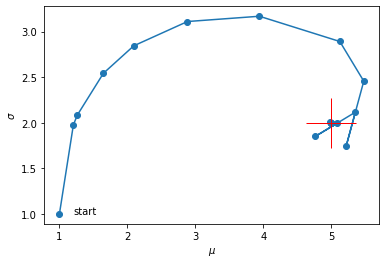

In [10]:
import matplotlib.pyplot as plt
x1, x2 = o3.loginfo['x'][:,0], o3.loginfo['x'][:,1]
plt.plot(x1, x2, '-o')
plt.plot(x1[-1:], x2[-1:], '-o', color='red', markersize=50, marker='+')
plt.text(1.2, 1, 'start')
plt.xlabel('$\mu$'); plt.ylabel('$\sigma$')
plt.show()